In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import datasets

In [1]:
from model import ScNN

# Generating Dataset

System: In 2D space, a free particle (A) and a particle (B) constrained to move on a circle.

The particle A is moving with initial velocity $u$ and the angular velocity of B is $\omega$. Their masses are $m_1\;\&\;m_2$ respectively.

Let the particle A collides with particle B at $(0, r).$ The final velocity of A is $v$ and final angular velocity of B is $\omega'$.

In [62]:
def generateData(p1inx_min=-10, p1inx_max=-5, v1inx_min=0.5, v1inx_max=1, v1iny_min=-0.5, v1iny_max=0.5, omega_min=-1, omega_max=1, r=1, m1=1, m2=1, units=5, samples=1000):
  p1inx = np.random.uniform(low=p1inx_min, high=p1inx_max, size=(samples,1))
  v1inx = np.random.uniform(low=v1inx_min, high=v1inx_max, size=(samples,1))
  v1iny = np.random.uniform(low=v1iny_min, high=v1iny_max, size=(samples,1))
  #v1finx = np.random.uniform(low=v1inx_min/2, high=v1iny_max/2, size=(samples,1))
  #v1finy = np.random.uniform(low=v1iny_min/2, high=v1iny_max/2, size=(samples,1))
  omega = np.random.uniform(low=omega_min, high=omega_max, size=(samples,1))

  v1finx_threshold = np.sqrt(v1inx**2 + m2*r**2*omega**2/m1)
  v1finx = np.random.uniform(low=-v1finx_threshold/1.1, high=v1finx_threshold/1.1, size=(samples, 1))
  v1finy = v1iny

  t_collision = -p1inx/v1inx

  p1iny = r - v1iny*t_collision
  #p2inx = -r*np.cos(omega*t_collision)
  #p2iny = -r*np.sin(omega*t_collision)

  l2in = m2*omega*r**2
  l1in = m1*(p1inx*v1iny - p1iny*v1inx)
  lin = l1in + l2in

  t_pre_collision = np.linspace(start=t_collision-5, stop=t_collision, num=units, axis=1)[:,:,0]
  t_post_collision = np.linspace(start=t_collision, stop=t_collision+5, num=units, axis=1)[:,:,0]
  #step = 10/units
  #diff = np.random.uniform(low=-step/units, high=step/units, size=(samples, units))
  #t_pre_collision = t_pre_collision + diff
  #diff = np.random.uniform(low=-step/units, high=step/units, size=(samples, units))
  #t_post_collision = t_post_collision + diff
  #t_pre_collision = np.random.uniform(low=t_collision-10, high=t_collision-1, size=(samples, units))
  #t_post_collision = np.random.uniform(low=t_collision+1, high=t_collision+10, size=(samples, units))

  p1x_pre = p1inx + v1inx*t_pre_collision
  p1y_pre = p1iny + v1iny*t_pre_collision
  p2x_pre = -r*np.sin(omega*(t_pre_collision-t_collision))
  p2y_pre = r*np.cos(omega*(t_pre_collision-t_collision))
  #p2x_pre = p2inx + r*np.cos(omega*t_pre_collision)
  #p2y_pre = p2iny + r*np.sin(omega*t_pre_collision)
  #p1x_post = p1inx + v1finx*t_post_collision
  #p1y_post = p1iny + v1finy*t_post_collision
  p1x_post = v1finx*(t_post_collision-t_collision)
  p1y_post = r + v1finy*(t_post_collision-t_collision)

  #l2fin = -m2*r*v1inx
  #l1fin = lin - l2fin
  #omega_fin = l2fin/(m2*r**2)
  omega_fin = omega + (v1finx - v1inx)*m1/(m2*r)

  p2x_post = -r*np.sin(omega_fin*(t_post_collision-t_collision))
  p2y_post = r*np.cos(omega_fin*(t_post_collision-t_collision))
  #p2x_post = r*np.cos(omega_fin*(t_post_collision-t_collision))
  #p2y_post = r*(1 + np.sin(omega_fin*(t_post_collision-t_collision)))

  t_prediction = t_collision + 5
  p2x_prediction = -r*np.sin(omega_fin*(t_prediction-t_collision))
  p2y_prediction = r*np.cos(omega_fin*(t_prediction-t_collision))

  return t_pre_collision, p1x_pre, p1y_pre, p2x_pre, p2y_pre, t_collision, t_post_collision, p1x_post, p1y_post, p2x_post, p2y_post, t_prediction, p2x_prediction, p2y_prediction, lin

In [63]:
samples = int(1e1)
units=50
t_pre_collision, p1x_pre, p1y_pre, p2x_pre, p2y_pre, t_collision, t_post_collision, p1x_post, p1y_post, p2x_post, p2y_post, t_prediction, p2x_prediction, p2y_prediction, lin = generateData(units=units, samples=samples)

[]

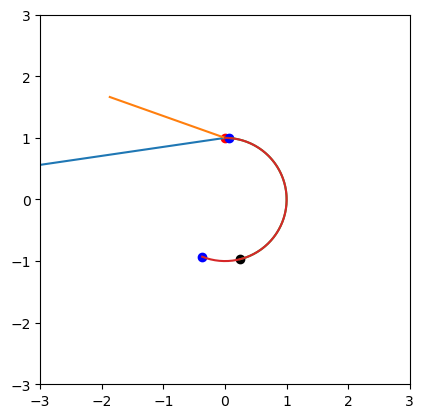

In [64]:
index1 = 2
plt.plot(p1x_pre[index1], p1y_pre[index1])
plt.plot(p1x_post[index1], p1y_post[index1])
plt.plot(p2x_pre[index1], p2y_pre[index1])
plt.plot(p2x_post[index1], p2y_post[index1])

plt.scatter(p2x_pre[index1,0], p2y_pre[index1,0], c='black')
plt.scatter(p2x_pre[index1,-1], p2y_pre[index1,-1], c='red')
plt.scatter(p2x_post[index1,[1,-1]], p2y_post[index1,[1,-1]], c='blue')
ax = plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')
plt.plot()

## Create and Train Model

In [65]:
train_samples = int(5e5)
t_pre_collision_train, p1x_pre_train, p1y_pre_train, p2x_pre_train, p2y_pre_train, t_collision_train, t_post_collision_train, p1x_post_train, p1y_post_train, p2x_post_train, p2y_post_train, t_prediction_train, p2x_prediction_train, p2y_prediction_train, lin_train = generateData(omega_min=0.1, omega_max=1.5, samples=train_samples)
print(t_pre_collision_train.shape)
print(p1x_pre_train.shape)
print(p2x_pre_train.shape)

(500000, 5)
(500000, 5)
(500000, 5)


In [66]:
collision = ScNN(input_size=30, encoder_layer=[150,100], latent_size=1, question_size=16, decoder_layer=[100,100], output_size=2, beta_rec=2, beta_kl=0, activation='tanh')

In [67]:
combined_input = keras.layers.Concatenate()([t_pre_collision_train, p1x_pre_train, p1y_pre_train, t_pre_collision_train, p2x_pre_train, p2y_pre_train])
combined_question = keras.layers.Concatenate()([t_prediction_train, t_post_collision_train, p1x_post_train, p1y_post_train])
combined_answer = keras.layers.Concatenate()([p2x_prediction_train, p2y_prediction_train])

In [68]:
learning_rate = 1e-3
batch_size=500
epochs=100

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
collision.fit({'time_series': combined_input, 't_question': combined_question, 'answer': combined_answer}, batch_size=batch_size, epochs=epochs)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 1.4767 - total_loss: 1.4767
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0416 - total_loss: 0.0416
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0139 - total_loss: 0.0139
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0071 - total_loss: 0.0071
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0045 - total_loss: 0.0045
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0036 - total_loss: 0.0036
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0031 - total_loss: 0.0031
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.00

In [79]:
learning_rate = 5e-4
batch_size=500
epochs=100

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
collision.fit({'time_series': combined_input, 't_question': combined_question, 'answer': combined_answer}, batch_size=batch_size, epochs=epochs)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.0017 - total_loss: 0.0017
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 3.0946e-05 - total_loss: 3.0946e-05
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 1.1952e-04 - total_loss: 1.1952e-04
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 1.1314e-04 - total_loss: 1.1314e-04
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 1.4018e-04 - total_loss: 1.4018e-04
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 7.3882e-05 - total_loss: 7.3882e-05
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 1.1907e-04 - total_loss: 1.1907e-04
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step -

In [87]:
learning_rate = 1e-4
batch_size=500
epochs=50

collision.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
collision.fit({'time_series': combined_input, 't_question': combined_question, 'answer': combined_answer}, batch_size=batch_size, epochs=epochs)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 5.2262e-05 - total_loss: 5.2262e-05
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 3.9998e-06 - total_loss: 3.9998e-06
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 6.6763e-06 - total_loss: 6.6763e-06
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 6.2216e-06 - total_loss: 6.2216e-06
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 6.1311e-06 - total_loss: 6.1311e-06
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 6.5718e-06 - total_loss: 6.5718e-06
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 5.9947e-06 - total_loss: 5.9947e-06
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step -

# Validating the model

The test sample is similarly generated. The answer to the question is predicted by the model for each sample.

In [69]:
test_samples = int(5e4)
t_test_pre_collision, p1x_test_pre, p1y_test_pre, p2x_test_pre, p2y_test_pre, t_test_collision, t_test_post_collision, p1x_test_post, p1y_test_post, p2x_test_post, p2y_test_post, t_test_prediction, p2x_test_prediction, p2y_test_prediction, lin_test = generateData(omega_min=0.1, omega_max=1.5, units=5, samples=test_samples)

[]

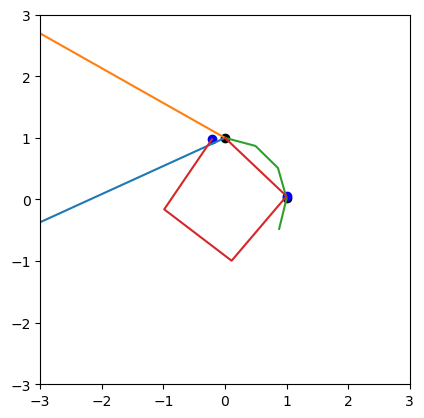

In [70]:
index1 = 10
plt.plot(p1x_test_pre[index1], p1y_test_pre[index1])
plt.plot(p1x_test_post[index1], p1y_test_post[index1])
plt.plot(p2x_test_pre[index1], p2y_test_pre[index1])
plt.plot(p2x_test_post[index1], p2y_test_post[index1])

plt.scatter(p2x_test_pre[index1,[1,-1]], p2y_test_pre[index1,[1,-1]], c='black')
plt.scatter(p2x_test_post[index1,[1,-1]], p2y_test_post[index1,[1,-1]], c='blue')
ax = plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')
plt.plot()

In [71]:
combined_observation_test = keras.layers.Concatenate()([t_test_pre_collision, p1x_test_pre, p1y_test_pre, t_test_pre_collision, p2x_test_pre, p2y_test_pre])
combined_question_test = keras.layers.Concatenate()([t_test_prediction, t_test_post_collision, p1x_test_post, p1y_test_post])

In [88]:
z_mu, z_logvar, z, x_test_prediction = collision.predict([combined_observation_test, combined_question_test])

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step


In [89]:
x_true = np.column_stack((p2x_test_prediction, p2y_test_prediction))
error_squared = (x_test_prediction - x_true)**2

In [90]:
mse = error_squared.sum(axis=1).mean()
mse

2.6667829977850103e-06

[]

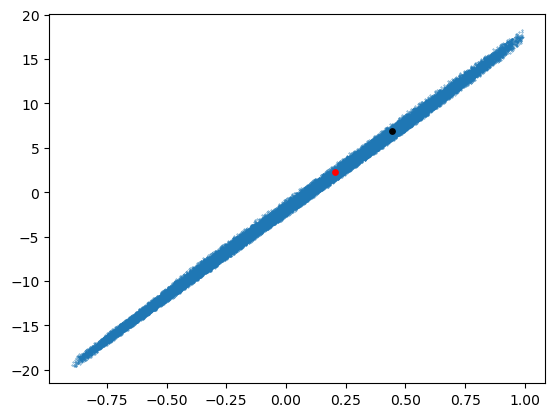

In [94]:
plt.scatter(lin_test, z, s=0.1)
plt.scatter(lin_test[1], z[1], s=15, c='black')
plt.scatter(lin_test[3], z[3], s=15, c='red')
#plt.scatter(x_test_prediction[:,0], x_true[:,0], s=0.5)
ax = plt.gca()
#ax.set_ylim(-2,2)
#ax.set_aspect('equal')
plt.plot()

The x-axis is the total angular momentum of the particles. y-axis is the output of the latent layer.

We see that the hidden layer varies linearly with the total angular momentum of the particles indicating that scinet has learned to extract the total angular momentum from the data which is a conserved quantity one uses to calculate the position of one of the particles.

In [ ]:
def MSE(x_pred, x_ans, batch_size=10):
  mse = 0
  start = 0
  end = batch_size
  num_batches = int(x_pred.shape[0]/batch_size)

  for batch in range(num_batches):
    mse = (np.square(x_pred[start:end] - x_ans[start:end])).sum()
    start += batch_size
    end += batch_size

  return mse.mean()

In [ ]:
mse = MSE(x_test_prediction, x_test_ans, batch_size=1000)

ValueError: operands could not be broadcast together with shapes (1000,1) (200,1) 

In [ ]:
mu = x_test_ans.mean()
mu

0.004429453935575459

In [ ]:
np.sqrt(mse)

In [ ]:
t0, t1 = 0, 10
b0, b1 = 0.1, 1
k0, k1 = 5, 10
N_grid = 100

B = np.linspace(b0, b1, N_grid)
K = np.linspace(k0, k1, N_grid)

b_grid, k_grid = np.meshgrid(B, K)
layer_z = [np.zeros(N_grid**2).reshape(b_grid.shape)]*3
layer_mean = [np.zeros(N_grid**2).reshape(b_grid.shape)]*3
layer_logvar = [np.zeros(N_grid**2).reshape(b_grid.shape)]*3

for i in range(N_grid):
  for j in range(N_grid):
    b, k = b_grid[i,j], k_grid[i,j]
    t, xt_series = generateTrajectory(t0=t0, t1=t1, b=b, k=k, samples=50)
    mean, log_var, z = encoder(xt_series)
    z = z.numpy().flatten()
    layer_z[0][i,j] = z[0]
    layer_z[1][i,j] = z[1]
    layer_z[2][i,j] = z[2]

    z = mean.numpy().flatten()
    layer_mean[0][i,j] = z[0]
    layer_mean[1][i,j] = z[1]
    layer_mean[2][i,j] = z[2]

    z = log_var.numpy().flatten()
    layer_logvar[0][i,j] = z[0]
    layer_logvar[1][i,j] = z[1]
    layer_logvar[2][i,j] = z[2]

In [ ]:
t, xt_series = generateTrajectory(t0=t0, t1=t1, b=0.1, k=5, samples=50)
mean, log_var, zout = encoder(xt_series)

In [ ]:
print(mean)
print(log_var)
print(zout)

tf.Tensor([[-0.28245395 -0.3753568   0.39236444]], shape=(1, 3), dtype=float32)
tf.Tensor([[ 0.01279005  0.04746556 -0.1887543 ]], shape=(1, 3), dtype=float32)
tf.Tensor([[ 0.01408318 -0.30462527 -0.50230145]], shape=(1, 3), dtype=float32)


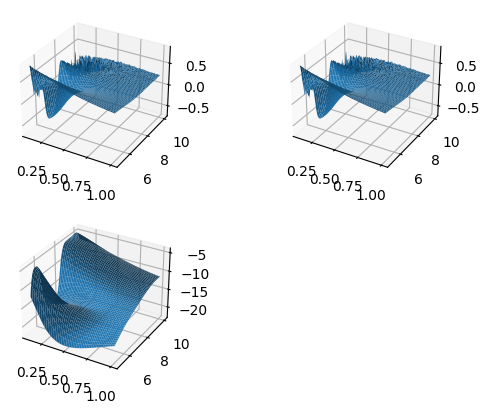

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'})
plt.xlabel('b')
plt.ylabel('k')
#ax.set_xlim(0.6, 1)
#ax.set_ylim(5, 10)
#for a1 in ax:
 # for a2 in a1:
  #  z=a2.set_zlim3d(-1, 1)

ax[0,0].plot_surface(b_grid, k_grid, layer_z[0])
ax[0,1].plot_surface(b_grid, k_grid, layer_z[1])
ax[1,0].plot_surface(b_grid, k_grid, layer_logvar[2])
fig.delaxes(ax[1,1])
plt.show()

Below, the model is provided a time series of position as an observation and the position of the pendulum is asked for a range of time to obtain the predicted trajectory of the pendulum.

In [ ]:
#generate observation data and test samples with a fixed value of spring constant and damping parameter
samples = 200

#observation data
t_obs, x_obs = generateTrajectory(t0=0, t1=5, b=0.5, k=5, samples=50)
#test questions as array of times and the corresponding answer as the position of the pendulum
t_ques, x_true_ans = generateTrajectory(t0=0, t1=10, b=0.5, k=5, samples=samples)

In [ ]:
z_mu = np.zeros(samples*3).reshape(samples, 3)
z_logvar = np.zeros(samples*3).reshape(samples, 3)
z = np.zeros(samples*3).reshape(samples, 3)
#array to store the predicted answers of the model
x_pred_ans = np.zeros(samples).reshape(1,samples)

#generate answer to each questions
for i in range(samples):
  z_mu[i:i+1, :], z_logvar[i:i+1, :], z[i:i+1,:], x_pred_ans[:,i:i+1] = pendulum.predict([x_obs, t_ques[:,i:i+1]], verbose=0)

In [ ]:
t_ques = t_ques.reshape(-1,1)
x_true_ans = x_true_ans.reshape(-1,1)
x_pred_ans = x_pred_ans.reshape(-1,1)

[]

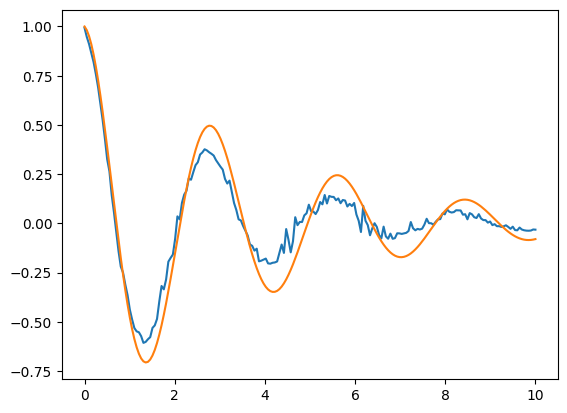

In [ ]:
plt.plot(t_ques, x_pred_ans)
plt.plot(t_ques, x_true_ans)
plt.plot()

#Denoising using Autoencoder

In [ ]:
variational_autoencoder = VAE(encoder, decoder, beta_rec=10., beta_kl=1)
variational_autoencoder.compile(optimizer='adam')
variational_autoencoder.fit(x_train_reshaped, x_train_reshaped, batch_size=128, epochs=10)

In [ ]:
latent_z_mu, latent_z_logvar, x_prediction_reshaped = variational_autoencoder.predict(x_test_reshaped)

Let us introduce some noise to the images and see how the autoencoder performs on the noised images.

In [ ]:
#create noises for the training and test datasets as random values
train_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_train_reshaped.shape[1]))
test_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_test_reshaped.shape[1]))

In [ ]:
#add the noise
x_train_noise = x_train_reshaped + train_noise
x_test_noise = x_test_reshaped + test_noise
#clip the noise in the range [0,1]
x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

We see that the encoder is performing badly for the noised data. This is because the encoder is not trained to remove the noise. So, lets pass the encoder noised data and train it to produce denoised images.